# Numerical Integration of the Landau-Zener Model for Non-Adiabatic Transitions

Copyright (C) 2021, Oriol Vendrell <oriol.vendrell@uni-heidelberg.de>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

In [1]:
import numpy as np
import scipy as sp
import scipy.integrate as spi

import matplotlib.pyplot as plt
#plt.rc('text', usetex=True)

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

The Landau-Zener model consists of a two-level system represented by the real-symmetric Hamiltonian matrix
\begin{align}
    \mathbf{W}(x) =
    \begin{pmatrix}
        W_{11}(x) & W_{12} \\
        W_{12} & W_{22}(x)
    \end{pmatrix}
\end{align}
depending on the parameter $x$, which in our case is assumed to represent an atomic displacement in a molecule.
The diagonal elements correspond to the energy of two diabatic electronic states, which are assumed
to have a constant slope with respect to $x$ and to cross at the origin:
\begin{align}
    W_{11}(x) & =\frac{1}{2}F_{12}x \\
    W_{22}(x) & =-\frac{1}{2}F_{12}x.
\end{align}
where $\frac{d}{dx}(W_{11}-W_{22})=F_{12}$ is the slope of the energy difference.

One assumes as well that the coupling term $W_{12}$ is constant.

Now, further assuming that the parameter $x$ varies with contant velocity, $x=vt$, one arrives at the final form for the time-dependent Hamiltonian:
\begin{align}
    \mathbf{W}(t) =
    \begin{pmatrix}
        \frac{1}{2}F_{12} v t & W_{12} \\
        W_{12}                & - \frac{1}{2}F_{12} v t
    \end{pmatrix}
    =
    \begin{pmatrix}
        \frac{1}{2} \alpha t & W_{12} \\
        W_{12}                & - \frac{1}{2} \alpha t
    \end{pmatrix}
\end{align}

Finally, the model depends on two parameters. $\alpha$ determines the speed of change of the energy gap. $W_{12}$ is the
coupling matrix element between both diabatic states.

The analytical expression for the asymptotic probability transfer reads
\begin{align}
    P_{tr} = e^{-\frac{2\pi}{\hbar}\frac{|W_{12}|^2}{\alpha}}
\end{align}

In [2]:
# Unit transformations
au2ev = 27.21139613178773
ev2au = 1.0/au2ev
au2an = 0.529177249
an2au = 1.0/au2an
au2fs = 0.024188843341
fs2au = 1.0/au2fs

# Model Parameters
alpha = 0.5*ev2au/fs2au # Energy gap change-rate in eV/fs
G0 = 0.1*ev2au          # Gap at the avoided crossing in eV ; W12 = G0/2.0

# Integration parameters
T0 = 15.0*fs2au  # the TDSE is numerically integrated in the range [-T0, T0]
DT = 0.1*fs2au 

In [3]:
def Ptr(a, w):
    return np.exp(-2.0*np.pi*w**2/a)

We integrate now the TDSE
\begin{align}
    \begin{pmatrix}
        \dot{c}_1(t)\\
        \dot{c}_2(t)
    \end{pmatrix}
    =
    \frac{-i}{\hbar}
    \begin{pmatrix}
        \frac{1}{2} \alpha t & W_{12} \\
        W_{12}                & - \frac{1}{2} \alpha t
    \end{pmatrix}
    \begin{pmatrix}
        c_1(t)\\
        c_2(t)
    \end{pmatrix}
\end{align}
numerically.

In [4]:
def integrateLZ(g=G0, a=alpha, t0=T0, dt=DT):
    # Hamiltonian matrix
    W = np.zeros((2, 2), complex)
    W[0, 1] = g/2.0
    W[1, 0] = g/2.0
    def Wt(t):
        W[0, 0] = 0.5*a*t
        W[1, 1] = -W[0, 0]
        return W
    
    # Time derivative of coefficients
    def dtpsi(t, c):
        c = np.asarray(c, complex)
        return -1j*np.dot(Wt(t), c)
    
    # Integrate
    c0 = np.zeros(2, complex)
    c0[1] = 1.0
    r = spi.ode(dtpsi)
    r.set_integrator('zvode',nsteps=100000)
    r.set_initial_value(c0, -t0)
    tlst = []
    clst= []
    while r.successful() and r.t < t0:
        r.integrate(r.t+dt)
        tlst.append(r.t)
        clst.append(r.y.copy())
    tlst = np.array(tlst)
    clst = np.array(clst)
    return tlst, clst

In [5]:
def plot(g=G0, a=alpha, t0=T0, dt=DT):
    tlst, clst = integrateLZ(g, a, t0, dt)
    plt.ylim(0, 1)
    plt.xlim(-t0*au2fs, t0*au2fs)
    plt.xlabel('t [fs]', fontsize=16)
    plt.ylabel('$p_2(t)\equiv|c_2(t)|^2$', fontsize=16)
    plt.plot(tlst*au2fs, np.abs(clst[:, 1])**2, color='b')
    plt.plot(tlst*au2fs, np.ones(len(tlst))*Ptr(a, g/2.0), color='r')

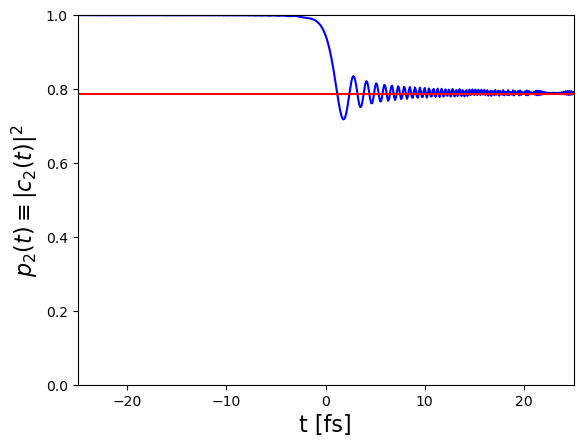

In [6]:
plot(0.3*ev2au, 0.90*ev2au/fs2au, 25*fs2au)

In [8]:
@widgets.interact(g=(0.1, 0.8, 0.1), a=(0.1, 1.0, 0.1), t0=(5, 25, 5), dt=(0.05, 0.5, 0.1))
def updatePlot(g, a, t0, dt):
    _g = g*ev2au
    _a = a*ev2au/fs2au
    _t0 = t0*fs2au
    _dt = dt*fs2au
    plot(_g, _a, _t0, _dt)

interactive(children=(FloatSlider(value=0.4, description='g', max=0.8, min=0.1), FloatSlider(value=0.5, descri…